# Statistical Arbitrage Cointegration

## Strategy

We find pairs of coins that are cointegrated using the augmented Engle-Granger two-step cointegration test via the `coint` function of [the `statsmodels.tsa.stattools` module](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html). We then employ pairs trading for the pairs we find.

## Method, Fixed Cointegrated Pairs

- Select the top cryptocurrencies from December 2020 and use historical price data from December 2020 to August 31, 2025. (We use data from December 2020 to avoid lookahead bias for our selection of cryptocurrencies in the universe.)
- Use the Engle-Granger two-step method to identify cointegrated pairs over the interval from December 2020 to December 2022.
- 


- Use the Engle-Granger two-step method to find cointegrated pairs over a trailing window of x weeks (x to be determined from experimentation) with a significance level $\alpha$ to be determined.
- Re-calculate the hedge ratio over periods of y weeks (y to be determined) and trade the spread between pairs of cointegrated coins during the training period.
- Analyze the results over the training period and select the variations of x, y, and $\alpha$ with the highest sharpe ratios (which should hopefully also have manageable maximum drawdown durations). Run those variations during the testing period.

## Data Collection

## Implementation

## Transaction Costs

## Results

TO BE FILLED IN

# Imports

In [1]:
import pandas as pd
import numpy as np

from ipynb.fs.full.utility_functions import (
    get_price_data,
    calculate_covariance_directly,
)
from statsmodels.tsa.stattools import coint
from datetime import datetime

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Price Data Collection

In [2]:
univ = [
    "BTCUSDT", "ETHUSDT", "ADAUSDT", "BNBUSDT", "XRPUSDT", "DOTUSDT", "MATICUSDT", "LTCUSDT", "BCHUSDT",
    "LINKUSDT", "XLMUSDT", "USDCUSDT", "EOSUSDT", "TRXUSDT", "XTZUSDT", "FILUSDT", "NEOUSDT", "DAIUSDT",
    "DASHUSDT", "VETUSDT", "ATOMUSDT", "AAVEUSDT", "UNIUSDT", "GRTUSDT", "THETAUSDT", "IOTAUSDT", "BUSDUSDT",
    "ZECUSDT", "YFIUSDT", "ETCUSDT", "WAVESUSDT", "COMPUSDT", "SNXUSDT", "DOGEUSDT", "MKRUSDT", "ZILUSDT",
    "SUSHIUSDT", "KSMUSDT", "OMGUSDT", "ONTUSDT", "ALGOUSDT", "EGLDUSDT", "BATUSDT", "DGBUSDT", "ZRXUSDT",
    "TUSDUSDT", "QTUMUSDT", "ICXUSDT", "AVAXUSDT", "RENUSDT", "HBARUSDT", "NEARUSDT", "LRCUSDT", "CELOUSDT",
    "KNCUSDT", "LSKUSDT", "OCEANUSDT", "QNTUSDT", "USTUSDT", "BANDUSDT", "MANAUSDT", "ENJUSDT", "ANTUSDT",
    "BNTUSDT", "ZENUSDT", "NMRUSDT", "RVNUSDT", "IOSTUSDT", "OXTUSDT", "CRVUSDT", "MATICUSDT", "HNTUSDT",
    "BALUSDT", "CHZUSDT"
]

px = get_price_data(univ, '4h', True, './class_project_input_prices.csv')
px

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,LTCUSDT,BCHUSDT,LINKUSDT,...,BNTUSDT,ZENUSDT,NMRUSDT,RVNUSDT,IOSTUSDT,OXTUSDT,CRVUSDT,HNTUSDT,BALUSDT,CHZUSDT
open_time,,,,,,,,,,,,,,,,,,,,,
2020-12-20 00:00:00,23353.97,646.62,0.16284,32.9681,0.56944,NaN,NaN,117.34,313.46,NaN,...,NaN,12.056,NaN,NaN,NaN,0.2492,NaN,1.41095,NaN,NaN
2020-12-20 04:00:00,23604.24,655.23,0.16638,33.6559,0.57916,NaN,NaN,121.30,340.00,NaN,...,NaN,12.107,NaN,NaN,NaN,0.2477,NaN,1.43156,NaN,NaN
2020-12-20 08:00:00,23549.50,652.88,0.16463,34.8228,0.57948,NaN,NaN,118.09,349.70,NaN,...,NaN,12.237,NaN,NaN,NaN,0.2477,NaN,1.44273,NaN,NaN
2020-12-20 12:00:00,23880.85,653.24,0.16542,35.0120,0.57798,NaN,NaN,119.10,361.21,NaN,...,NaN,12.074,NaN,NaN,NaN,0.2533,NaN,1.47130,NaN,NaN
2020-12-20 16:00:00,23932.71,649.82,0.16502,34.7042,0.57306,NaN,NaN,116.60,357.09,NaN,...,NaN,12.008,NaN,NaN,NaN,0.2503,NaN,1.43083,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-30 16:00:00,108921.64,4352.10,0.81950,856.7600,2.80720,3.816,NaN,110.23,542.00,23.36,...,0.725,7.240,16.62,0.01323,0.00342,0.0535,0.7646,NaN,NaN,0.03830
2025-08-30 20:00:00,108569.75,4374.56,0.82170,862.6200,2.81940,3.773,NaN,110.77,552.90,23.47,...,0.725,7.240,15.16,0.01323,0.00342,0.0535,0.7646,NaN,NaN,0.03830
2025-08-31 00:00:00,109155.73,4486.79,0.83590,863.4900,2.85180,3.867,NaN,111.67,551.30,23.90,...,0.764,7.240,15.21,0.01353,0.00342,0.0535,0.7936,NaN,NaN,0.04045


# Utility Functions

In [3]:
def find_cointegrated_pairs(data, significance_level=0.05):
    """
    Finds cointegrated pairs using the Engle-Granger two-step method.
    Returns a list of cointegrated pairs with their p-value.
    """
    n = data.shape[1]
    keys = data.columns
    pvalue_matrix = pd.DataFrame(np.ones((n, n)), index=keys, columns=keys)
    pairs = []

    for i in range(n):
        for j in range(i + 1, n):
            series1 = data[keys[i]]
            series2 = data[keys[j]]
            
            joint_non_na_series1 = series1.loc[series1.notna() & series2.notna()]
            joint_non_na_series2 = series2.loc[series1.notna() & series2.notna()]
            
            if len(joint_non_na_series1) == 0 or len(joint_non_na_series2) == 0:
                pvalue_matrix.loc[keys[i], keys[j]] = 1.0
                continue

            # Perform the cointegration test
            score, pvalue, _ = coint(joint_non_na_series1, joint_non_na_series2)
            pvalue_matrix.loc[keys[i], keys[j]] = pvalue

            if pvalue < significance_level:
                pairs.append((keys[i], keys[j], pvalue))
    return pvalue_matrix, pairs

# Collect Signal Values

In [4]:
find_coint_pairs_cutoff = datetime(2022, 1, 1, 0, 0)
#train_variants_cutoff = datetime(2023, 1, 1, 0, 0)

px_find_coint_pairs = px.loc[:find_coint_pairs_cutoff].iloc[:-1]
px_train_variants = px.loc[find_coint_pairs_cutoff:]
# px_test_variants = pd.DataFrame()

In [ ]:
# input_prices = px
# step = 6 * 7 * 4
significance_level = 0.05

# pvalue_matrix, pairs = find_cointegrated_pairs(px)

# for index in range(len(input_prices)):
#     if index < step or index % step != 0:
#         continue
    
#     pvalue_matrix, pairs = find_cointegrated_pairs(input_prices.iloc[(index-step):index], significance_level)
    
#     if len(pairs) > 0:
#         break

pvalue_matrix, pairs = find_cointegrated_pairs(px_find_coint_pairs, significance_level)

In [6]:
pairs

[('BTCUSDT', 'YFIUSDT', 0.033752949103717),
 ('ADAUSDT', 'DOTUSDT', 0.007718982658758317),
 ('BNBUSDT', 'YFIUSDT', 0.038408874052144534),
 ('XRPUSDT', 'OXTUSDT', 0.02541778849904355),
 ('DOTUSDT', 'XLMUSDT', 7.882890583150227e-05),
 ('DOTUSDT', 'ATOMUSDT', 0.037979480677433286),
 ('DOTUSDT', 'BUSDUSDT', 0.017665368266566006),
 ('DOTUSDT', 'YFIUSDT', 0.04147877817620386),
 ('DOTUSDT', 'OXTUSDT', 0.004288185816577091),
 ('LTCUSDT', 'UNIUSDT', 0.0319374921271664),
 ('LTCUSDT', 'YFIUSDT', 0.0029038792529071274),
 ('LTCUSDT', 'ZRXUSDT', 0.012804046495083737),
 ('LTCUSDT', 'KNCUSDT', 0.03838981709495283),
 ('LTCUSDT', 'OXTUSDT', 0.022073347774406168),
 ('BCHUSDT', 'NEOUSDT', 0.004511003547116222),
 ('BCHUSDT', 'UNIUSDT', 0.020957207418240677),
 ('BCHUSDT', 'YFIUSDT', 0.005614022237344317),
 ('BCHUSDT', 'COMPUSDT', 0.023591287553895196),
 ('BCHUSDT', 'KNCUSDT', 0.027627927272252138),
 ('XLMUSDT', 'NEOUSDT', 0.012102532576088513),
 ('XLMUSDT', 'YFIUSDT', 0.011024608763291671),
 ('XLMUSDT', 'ON

In [47]:
def calculate_spread_strat_data(px_train, coin_1, coin_2, step, avg_z_score_window):
    strat_data = pd.DataFrame()

    spread_data = pd.Series()
    beta_data = pd.Series()

    for index in range(step):
        spread_data[px_train.index[index]] = np.nan
        beta_data[px_train.index[index]] = np.nan

    for index in range(step, len(px_train)):
        coin_1_prices = px_train.iloc[(index-step+1):(index+1)][coin_1]
        coin_2_prices = px_train.iloc[(index-step+1):(index+1)][coin_2]
        calculated_cov = calculate_covariance_directly(coin_1_prices, coin_2_prices)

        beta = calculated_cov / coin_2_prices.var()

        spread = px_train.iloc[index][coin_1] - beta * px_train.iloc[index][coin_2]
        spread_data[px_train.index[index]] = spread
        beta_data[px_train.index[index]] = beta

    strat_data["spread"] = spread_data
    strat_data["beta"] = beta_data
    
    z_score = (strat_data["spread"] - strat_data["spread"].rolling(avg_z_score_window).mean()) / strat_data["spread"].rolling(avg_z_score_window).std()
    strat_data["z-score"] = z_score
    
    return strat_data


def simulate_trades(px_train, strat_data, coin_1, coin_2):
    money_earned = 0.0

    shifted_forward_strat_data = strat_data.shift()

    balance_record = pd.Series()

    coin_1_share_count = 0
    coin_2_share_count = 0.0

    # coin_1 ~ coin_2 * b + a
    # long 1 coin_1, short b coin_2

    for i in range(len(shifted_forward_strat_data)):
        open_time = shifted_forward_strat_data.index[i]
        is_currently_holding = coin_1_share_count != 0
        z_score = shifted_forward_strat_data.iloc[i]["z-score"]
        beta = shifted_forward_strat_data.iloc[i]["beta"]

        #print(f"{open_time}: {'Holding' if is_currently_holding else 'Not Holding'}")
        
        if np.isnan(px_train.iloc[i][coin_1]) or np.isnan(px_train.iloc[i][coin_2]):
            balance_record[open_time] = money_earned
            continue
        elif (z_score is None or np.isnan(z_score) or np.isnan(px_train.iloc[i][coin_1]) or 
            np.isnan(px_train.iloc[i][coin_2])):
            coin_1_share_count = 0
            coin_2_share_count = 0.0
        elif z_score > 1.75 and not is_currently_holding: # coin_1 currently overpriced, coin_2 underpriced
            coin_1_share_count = -1
            coin_2_share_count = beta
            money_earned -= (coin_1_share_count * px_train.iloc[i-1][coin_1] + coin_2_share_count * px_train.iloc[i-1][coin_2])
        elif z_score < -1.75 and not is_currently_holding: # coin_1 currently underpriced, coin_2 overpriced
            coin_1_share_count = +1
            coin_2_share_count = -beta
            money_earned -= (coin_1_share_count * px_train.iloc[i-1][coin_1] + coin_2_share_count * px_train.iloc[i-1][coin_2])
        elif (coin_1_share_count == -1 and z_score < 0.75) or (coin_1_share_count == 1 and z_score > -0.75):
            money_earned += coin_1_share_count * px_train.iloc[i-1][coin_1] + coin_2_share_count * px_train.iloc[i-1][coin_2]
            coin_1_share_count = 0
            coin_2_share_count = 0.0

        # current_position is at the end of the interval corresponding to row i
        current_position = coin_1_share_count * px_train.iloc[i][coin_1] + coin_2_share_count * px_train.iloc[i][coin_2]
        balance_record[open_time] = money_earned + current_position

    return balance_record

In [51]:
step = 6 * 7 * 5
avg_z_score_window = 6 * 7 * 5 * 2
coint_pairs_to_balance = dict()

for index, (coin_1, coin_2, z_score) in enumerate(pairs):
    if z_score < 0.01:
        strat_data = calculate_spread_strat_data(px_train_variants, coin_1, coin_2, step, avg_z_score_window)
        coint_pairs_to_balance[(coin_1, coin_2)] = simulate_trades(px_train_variants, strat_data, coin_1, coin_2)
        print(f"{index+1} / {len(pairs)}")

total_balance_record = sum(coint_pairs_to_balance.values())
total_balance_record

2 / 83
5 / 83
9 / 83
11 / 83
15 / 83
17 / 83
22 / 83
23 / 83
25 / 83
26 / 83
27 / 83
28 / 83
29 / 83
30 / 83
31 / 83
32 / 83
33 / 83
34 / 83
35 / 83
36 / 83
37 / 83
38 / 83
39 / 83
40 / 83
41 / 83
42 / 83
43 / 83
44 / 83
45 / 83
46 / 83
47 / 83
48 / 83
56 / 83
57 / 83
58 / 83
59 / 83
60 / 83
61 / 83
62 / 83
63 / 83
64 / 83
65 / 83
66 / 83
67 / 83
68 / 83
70 / 83
71 / 83
78 / 83
79 / 83


2022-01-01 00:00:00      0.000000
2022-01-01 04:00:00      0.000000
2022-01-01 08:00:00      0.000000
2022-01-01 12:00:00      0.000000
2022-01-01 16:00:00      0.000000
                          ...    
2025-08-30 16:00:00    772.790658
2025-08-30 20:00:00    772.845515
2025-08-31 00:00:00    772.733883
2025-08-31 04:00:00    772.850280
2025-08-31 08:00:00    772.832665
Length: 8030, dtype: float64

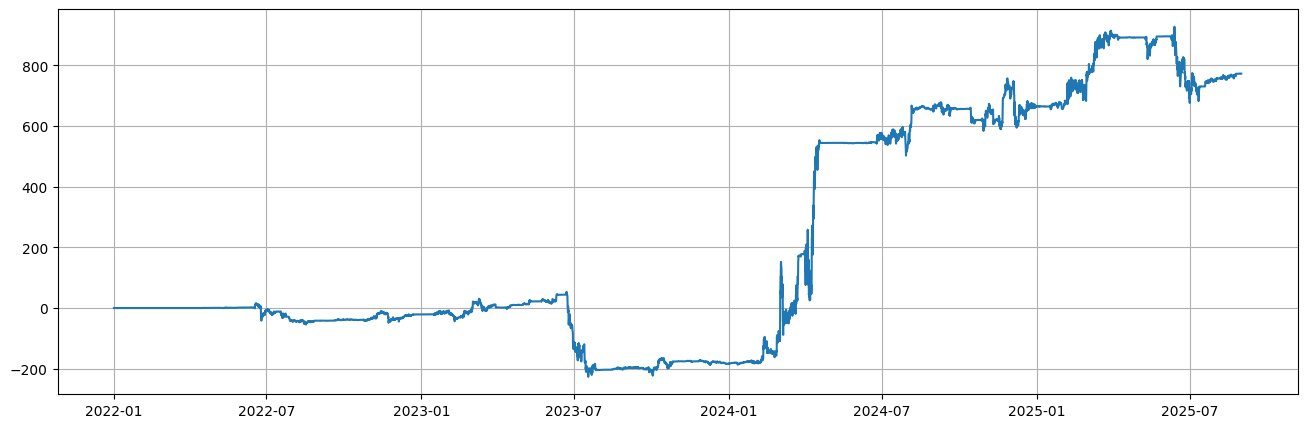

In [52]:
plt.figure(figsize=(16,5))
plt.plot(total_balance_record)

plt.grid()
plt.show()

In [20]:
# performance_data = pd.DataFrame({
#     "spread": spread_data
# })

# z_score = (performance_data - performance_data.rolling(step).mean()) / performance_data.rolling(step).std()

# performance_data["z_score"] = z_score
# performance_data

# z_score = (strat_data["spread"] - strat_data["spread"].rolling(avg_z_score_window).mean()) / strat_data["spread"].rolling(avg_z_score_window).std()
# strat_data["z-score"] = z_score

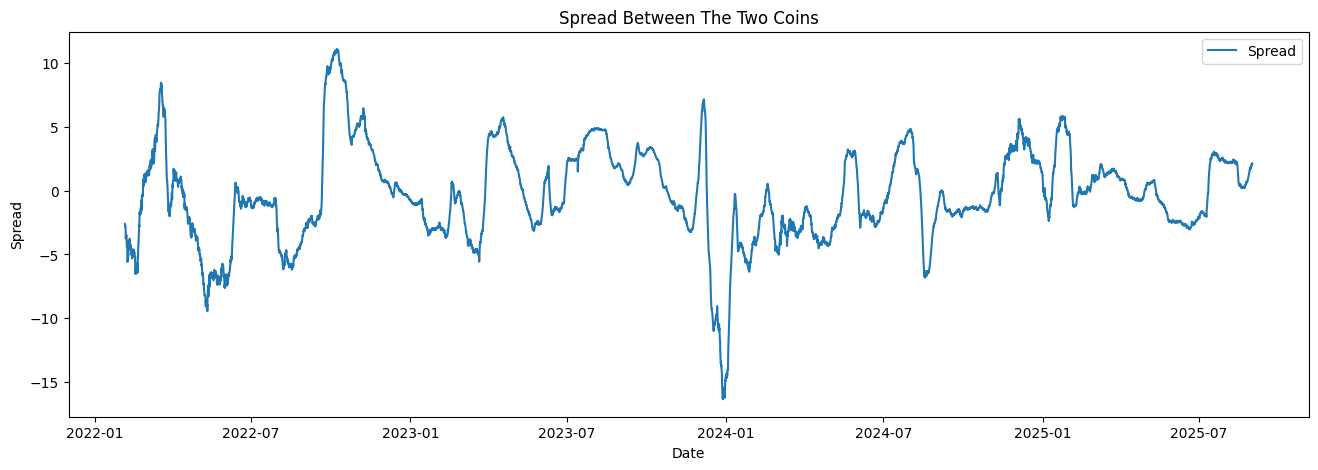

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))

plt.plot(strat_data["spread"], label='Spread')
# plt.axhline(pair_data.mean(), label="Spread Mean", color="black")
plt.title('Spread Between The Two Coins')
plt.xlabel('Date')
plt.ylabel('Spread')

plt.legend()
plt.show()

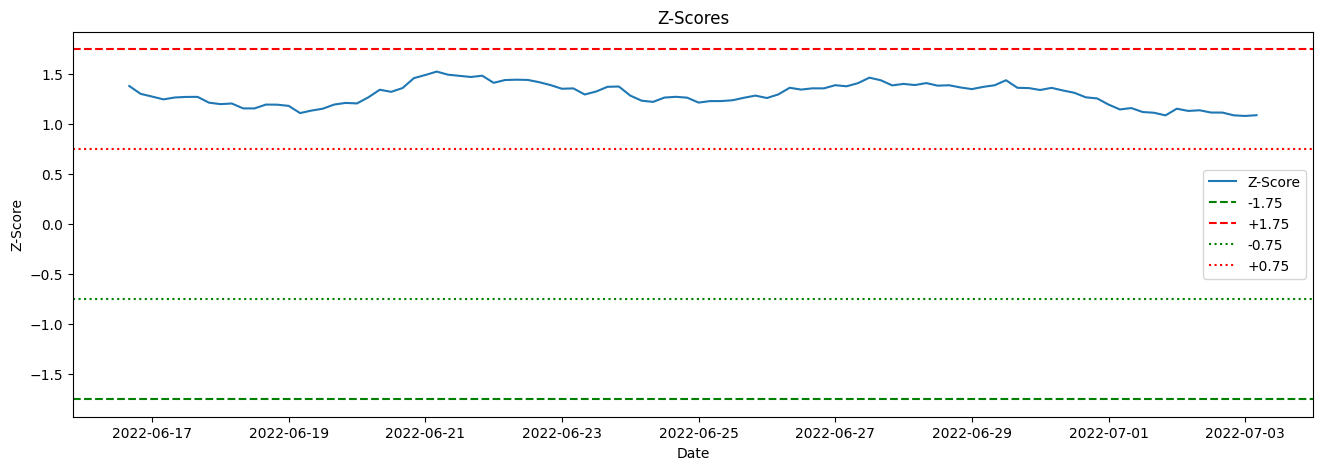

In [22]:
plt.figure(figsize=(16, 5))

plt.plot(strat_data["z-score"].iloc[1000:1100], label='Z-Score')
# plt.axhline(pair_data.mean(), label="Spread Mean", color="black")
plt.title('Z-Scores')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.axhline(-1.75, color="green", linestyle="--", label="-1.75")
plt.axhline(1.75, color="red", linestyle="--", label="+1.75")
plt.axhline(-0.75, color="green", linestyle="dotted", label="-0.75")
plt.axhline(0.75, color="red", linestyle="dotted", label="+0.75")

plt.legend()
plt.show()

In [23]:
strat_data

,spread,beta,z-score
2022-01-01 00:00:00,NaN,NaN,NaN
2022-01-01 04:00:00,NaN,NaN,NaN
2022-01-01 08:00:00,NaN,NaN,NaN
2022-01-01 12:00:00,NaN,NaN,NaN
2022-01-01 16:00:00,NaN,NaN,NaN
...,...,...,...
2025-08-30 16:00:00,2.010829,5.015757,0.660897
2025-08-30 20:00:00,1.991351,4.946276,0.647094
2025-08-31 00:00:00,2.103023,4.848754,0.702139
2025-08-31 04:00:00,2.118362,4.748295,0.706636


In [24]:
balance_record = simulate_trades(px_train_variants, strat_data, "DOTUSDT", "XLMUSDT")

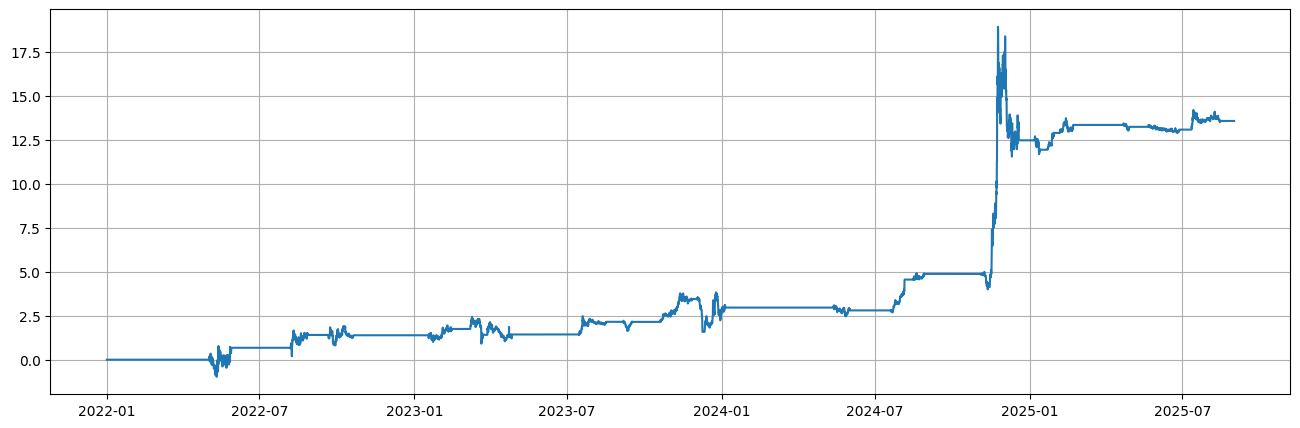

In [25]:
plt.figure(figsize=(16,5))
plt.plot(balance_record)

plt.grid()
plt.show()

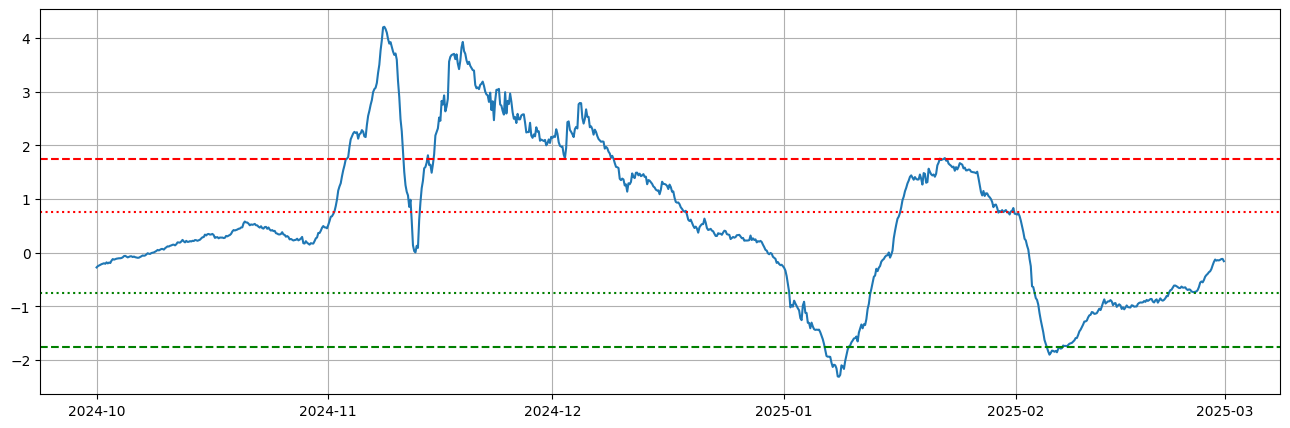

In [26]:
plt.figure(figsize=(16,5))
plt.plot(strat_data["z-score"].shift().loc[datetime(2024, 10, 1, 0, 0):datetime(2025, 2, 28, 20, 0)])

plt.axhline(-1.75, color="green", linestyle="--", label="-1.75")
plt.axhline(1.75, color="red", linestyle="--", label="+1.75")
plt.axhline(-0.75, color="green", linestyle="dotted", label="-0.75")
plt.axhline(0.75, color="red", linestyle="dotted", label="+0.75")

plt.grid()
plt.show()

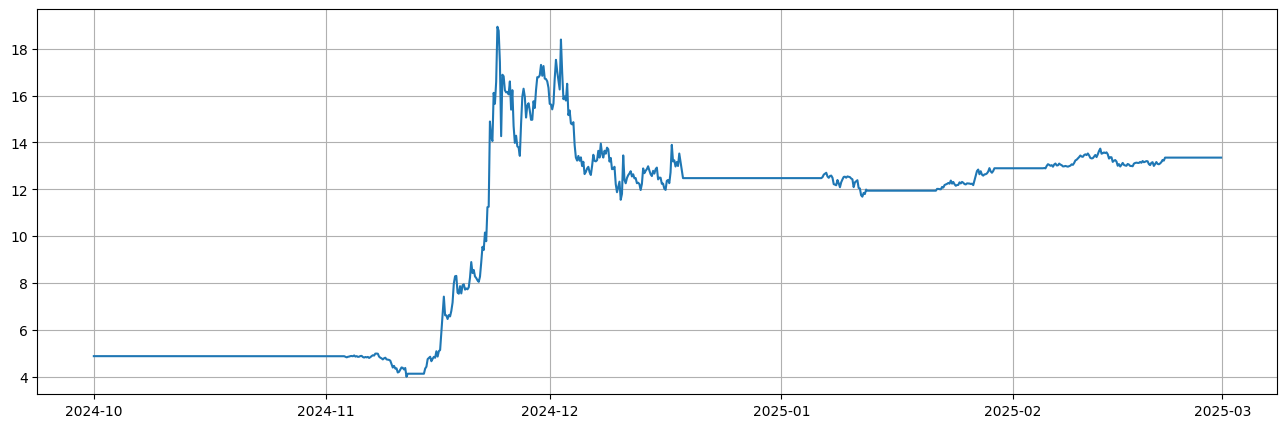

In [27]:
from datetime import datetime

plt.figure(figsize=(16,5))
plt.plot(balance_record.loc[datetime(2024, 10, 1, 0, 0):datetime(2025, 2, 28, 20, 0)])

plt.grid()
plt.show()

In [131]:
strat_data["z-score"].loc[datetime(2023, 1, 1, 0, 0)]

0.4533111731494062